# Exploratory data analysis

In [1]:

import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from matplotlib import pyplot as plt, rc_context, rc
plt.style.use('seaborn-deep')

We start by reading in the data.

In [2]:
foo = r'C:\Users\ACER\Desktop\python project\airqo/BandaHourly.csv'

In [3]:
ts= pd.read_csv(foo, parse_dates=True)


In [4]:
ts= pd.read_csv(foo, parse_dates=True)
#swaps day & month
ts.Date = pd.to_datetime(ts.Date, dayfirst=True)
ts = ts.set_index('Date')


In [5]:
ts

,s2_pm2_5
Date,
2019-11-27 13:00:00,39.366842
2019-11-27 14:00:00,33.868718
2019-11-27 15:00:00,38.259744
2019-11-27 16:00:00,73.879048
2019-11-27 17:00:00,75.360000
...,...
2021-11-15 19:00:00,50.853721
2021-11-15 20:00:00,37.073437
2021-11-15 21:00:00,53.398000


First, we look at some descriptive statistics about the data.

In [6]:
ts.describe()

,s2_pm2_5
count,11441.000000
mean,46.860934
std,34.239753
min,0.980667
25%,25.360256
50%,39.298750
75%,57.220000
max,500.000000


In [7]:
ts.head(5)

,s2_pm2_5
Date,
2019-11-27 13:00:00,39.366842
2019-11-27 14:00:00,33.868718
2019-11-27 15:00:00,38.259744
2019-11-27 16:00:00,73.879048
2019-11-27 17:00:00,75.360000


In [8]:
ts.tail()

,s2_pm2_5
Date,
2021-11-15 19:00:00,50.853721
2021-11-15 20:00:00,37.073437
2021-11-15 21:00:00,53.398000
2021-11-16 05:00:00,46.580000
2021-11-16 06:00:00,41.230000


Note that this data is on the hourly resolution; therefore, the max value is much higher than the average (or even the minimum) value of the daily data. Next, we try to visualize the time series to gain some insights.

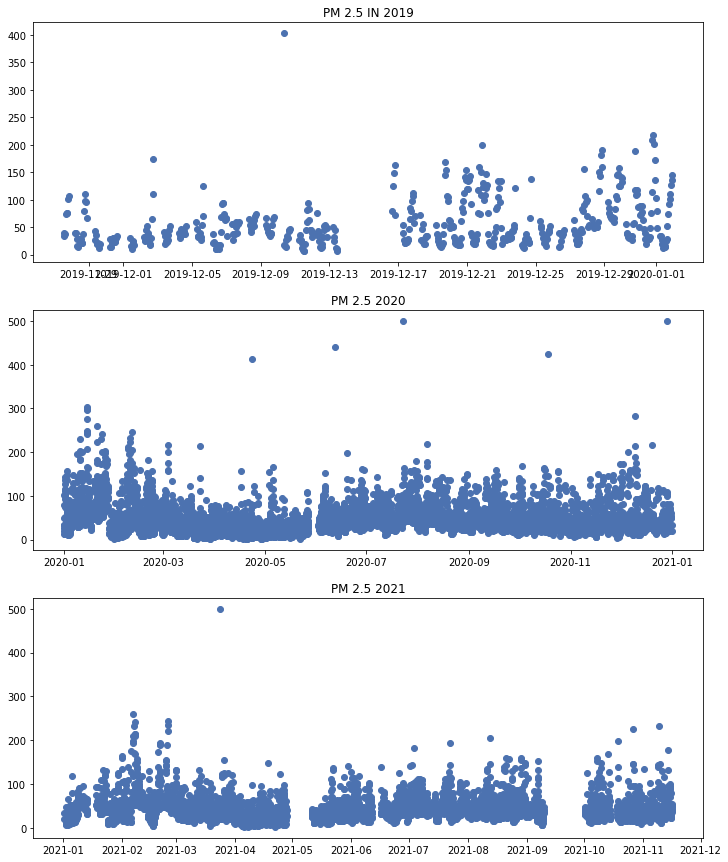

In [9]:
ts2019,ts2020,ts2021 = ts['2019-11-01':'2020-01-01'],ts['2020-01-01':'2021-01-01'],ts['2021-01-01':'2022-01-01']
fig,ax =  plt.subplots(3,figsize=(12,15))

ax[0].plot(ts2019,'o')
ax[0].set_title('PM 2.5 IN 2019')
ax[1].plot(ts2020,'o')
ax[1].set_title('PM 2.5 2020')
ax[2].plot(ts2021,'o')
ax[2].set_title('PM 2.5 2021')

plt.show()

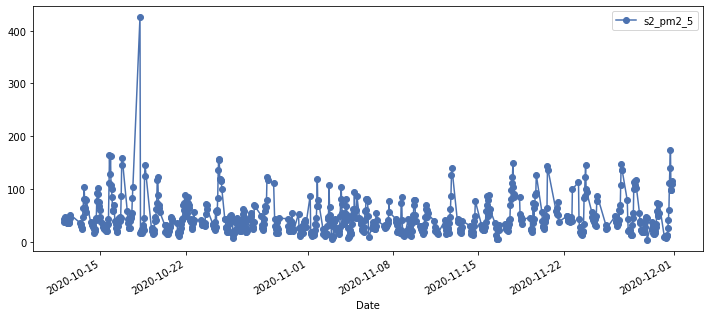

In [10]:
def plot(data, start, end):
    data.loc[start:end].plot(figsize=(12,5), style='o-')
    plt.show()  


plot(ts, '2020-10-12', '2020-11-30')

Since this is a time series, we should look at its autocorrelation function plot to identify any patterns that could potentially help us build common models such as ARIMA

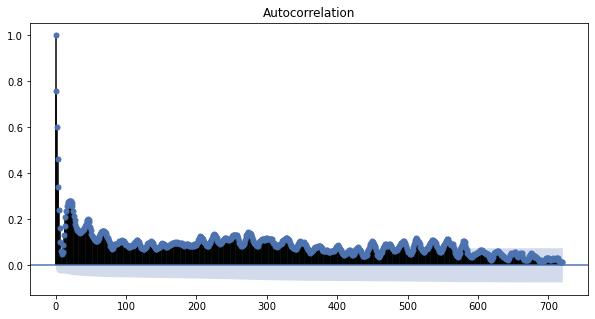

In [11]:
with rc_context():
    rc("figure", figsize=(10,5))
    plot_acf(ts['s2_pm2_5'], lags=720) # 720 hours, or 30 days
    plt.show()

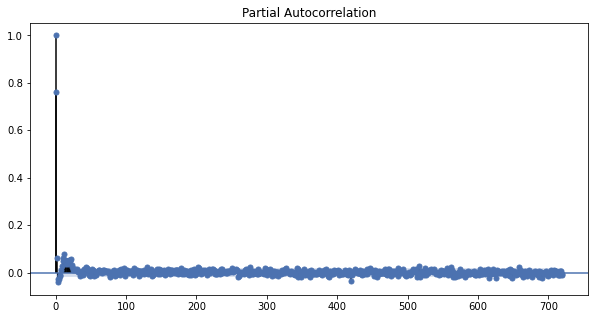

In [12]:
with rc_context(): # takes quite some time to run
    rc("figure", figsize=(10,5))
    plot_pacf(ts['s2_pm2_5'], lags=720)
    plt.show()

# TRENDS AND sESSONALITY 

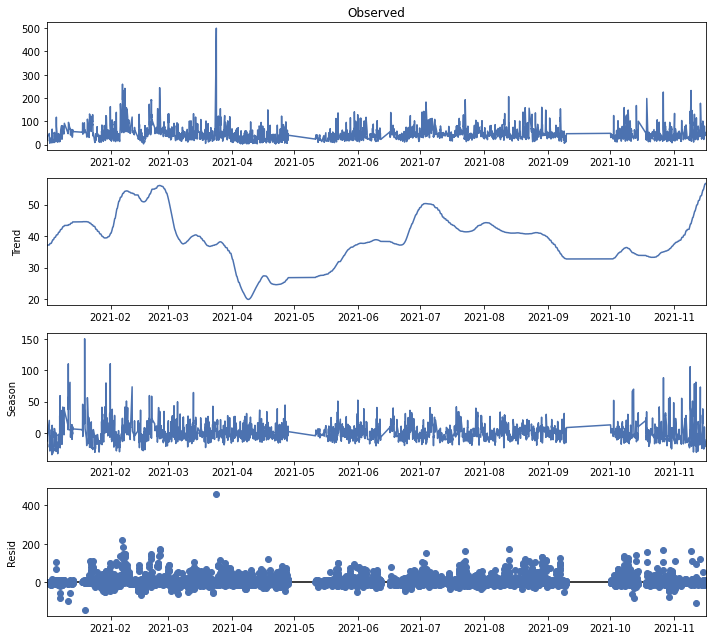

In [13]:
plt.rcParams.update({'figure.figsize':(10,9)})
stl = STL(ts2021,period=24*7,robust=True)
res = stl.fit()
fig = res.plot()

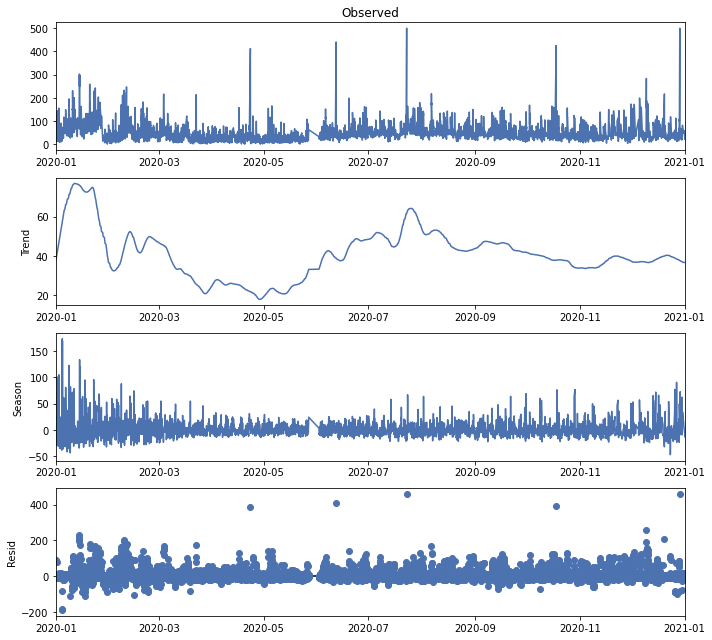

In [14]:
plt.rcParams.update({'figure.figsize':(10,9)})
stl = STL(ts2020,period=24*7,robust=True)
res = stl.fit()
fig = res.plot()

Now, we are pretty confident that the hourly pm 2.5  time series consists of three main components:
#A (yearly) trend that reaches bottom in April, a complex seasonality component that picks in aroun December and January and holiday effects

# Models: Prophet
## Loaded modules and preparing data

In [15]:
import pandas as pd
import numpy as np

# Facebook Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_seasonality
import prophet.plot

# Plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


First, load in the hourly data created

In [16]:
df= pd.read_csv(foo, parse_dates=True)
#swaps day & month
df.Date = pd.to_datetime(df.Date, dayfirst=True)
df= df.set_index('Date')


In [17]:
df

,s2_pm2_5
Date,
2019-11-27 13:00:00,39.366842
2019-11-27 14:00:00,33.868718
2019-11-27 15:00:00,38.259744
2019-11-27 16:00:00,73.879048
2019-11-27 17:00:00,75.360000
...,...
2021-11-15 19:00:00,50.853721
2021-11-15 20:00:00,37.073437
2021-11-15 21:00:00,53.398000


Next, we rename the columns for use in the models below. The models below expect the data to have a ds column (representing the timestamps/ date) and a y column (representing the PM 2.5 of the time series).

In [18]:
df.index.names = ['ds']
df.rename(columns={'s2_pm2_5':'y'}, inplace=True)

We divide the data into three sets: train, validation, and test sets. 
The test set starts from the timestamp 2021-10-27. In the remaing portion of the data, the first 80% of it is used for training, and the remaining 20% is used for validation. However, we may choose not to generate the validation set if it's not necessary.

In [19]:
df.tail()

,y
ds,
2021-11-15 19:00:00,50.853721
2021-11-15 20:00:00,37.073437
2021-11-15 21:00:00,53.398000
2021-11-16 05:00:00,46.580000
2021-11-16 06:00:00,41.230000


In [20]:
def train_val_test_split(df, validation=True):
    train_end = '2021-10-01 00:00:00'

    train_val = df.loc[:train_end, :]
    test_df = df.loc[train_end:, :]

    # Let the ds indexing column be its own column as is required by the models below.
    for df in [train_val, test_df]:
        df.reset_index(inplace=True)
        
    if not validation:
        return train_val, test_df

    n = len(train_val)
    cutoff = int(n*0.8)

    train_df = train_val[:cutoff]
    val_df = train_val[cutoff:]
    return train_df, val_df, test_df

In [21]:
train_df, val_df, test_df = train_val_test_split(df)

# Prophet: Description

Prophet is a open-source project from Facebook that aims to model time series data and make reliable forecasts. Essentially, a Prophet model is an additive model with several components: a seasonal component with multiple levels (e.g., yearly, weekly, daily, and user-defined seasonalities), a trend component which can be highly non-linear, and holiday effects. Prophet fits models with Stan, a probabilistic programming framework. Prophet estimates the parameters with maximum a posteriori estimates by default.

The model can typically be expressed with the following formula:

y
t
=
g
(
t
)
+
s
(
t
)
+
h
(
t
)
where:

y
t
 is the time series

g
(
t
)
 is a (possibly smooth and nonlinear) function of the trend

s
(
t
)
 represents the seasonal, periodic changes (e.g., yearly and weekly seasonalities)

h
(
t
)
 models the effects of holidays, whose schedule may be irregular.

For more information, please see the article (Taylor et al., 2018).

In [39]:
# Helper functions for Prophet model fitting and plotting.

def to_exp(df, colnames):
    res = df.copy()
    for colname in colnames:
        res[colname] = res[colname].apply(np.exp)
    return res


def to_log(df, colnames):
    res = df.copy()
    for colname in colnames:
        res[colname] = res[colname].apply(np.log)
    return res


def plot(forecast, train, x1,x2):
    """
    Plots two time series 'forecast' and 'train' in one plot mainly to compare them.
    Also plots the first time series against the second time series to determine 
    how similar they are. x1 is the starting time point and x2 is the ending time point.
    """
    yhat = forecast.set_index('ds').loc[x1:x2, 'yhat']
    y = train.set_index('ds').loc[x1:x2, 'y']
    plt.figure(figsize=(15,7))
    plt.plot(yhat, 'o-', label='Estimated')
    plt.plot(y, 'o', label='True')
    lower = forecast.set_index('ds').loc[x1:x2, 'yhat_lower']
    upper = forecast.set_index('ds').loc[x1:x2, 'yhat_upper']
    plt.fill_between(yhat.index, lower, upper, alpha=0.2)
    plt.legend()
    plt.show()
    plt.figure(figsize=(10,5))
    plt.scatter(x=y, y=yhat)
    min_x = int(np.floor(np.min([yhat.min(), y.min()]))) 
    max_x = int(np.ceil(np.max([yhat.max(), y.max()])))
    r = range(min_x,max_x)
    plt.plot(r, r, 'r', label='y=x')
    plt.title('True (x-axis) against estimated (y-axis)')
    plt.legend()
    plt.show()
    

def acf_res(forecast, train):
    """
    Plots a autocorrelation plot of the residuals (y-true minus y-predicted) for training data.
    """
    date_range = train['ds']
    res = train.set_index('ds')['y'] - forecast.set_index('ds').loc[date_range, 'yhat']
    plot_acf(res)

    
def is_spring(ds):
    return ds.month in [3,4,5]

    
def is_summer(ds):
    """
    Determines whethere a timestamp ds is in the summer or not.
    """
    return ds.month in [6,7,8]


def is_winter(ds):
    """
    Determines whether a timestamp ds is in the winter.
    """
    return ds.month in [12,1,2]


def is_autumn(ds):
    return ds.month in [9,10,11]
    
    
def is_weekend(ds):
    """
    Determines whether a timestamp ds is in the weekend.
    """
    return ds.day_name() in ['Saturday', 'Sunday']


def is_weekday(ds):
    """
    Determines whether a timestamp ds is a weekday.
    """
    return not is_weekend(ds)


def is_winter_weekday(ds):
    """
    Determines whether a timestamp ds is a winter weekday.
    """
    return is_winter(ds) and is_weekday(ds)


def is_winter_weekend(ds):
    """
    Determines whether a timestamp ds is a winter weekend.
    """
    return is_winter(ds) and is_weekend(ds)


def is_summer_weekday(ds):
    """
    Determines whether a timestamp ds is a summer weekday.
    """
    return is_summer(ds) and is_weekday(ds)


def is_summer_weekend(ds):
    """
    Determines whether a timestamp ds is a summer weekend.
    """
    return is_summer(ds) and is_weekend(ds)


def is_first_half(ds):
    """
    Determines whether a timestamp is in the first half of a year (spring-summer)
    """
    return (ds.month >= 2 and ds.month <= 7)


def is_second_half(ds):
    """
    Determines whether a timestamp is in the second half of a year (autumn-summer)
    """
    return not is_first_half(ds)


def is_spring_weekday(ds):
    return is_spring(ds) and is_weekday(ds)


def is_spring_weekend(ds):
    return is_spring(ds) and is_weekend(ds)


def is_autumn_weekday(ds):
    return is_autumn(ds) and is_weekday(ds)


def is_autumn_weekend(ds):
    return is_autumn(ds) and is_weekend(ds)


def add_custom_seasonality(df):
    """
    Augments the dataframe df with several columns determining
    whether the corresponding datapoints belong to different seasoonalities. 
    """
    df = df.assign(
                       spring_weekday = df['ds'].apply(is_spring_weekday),
                       spring_weekend = df['ds'].apply(is_spring_weekend),
                       summer_weekday = df['ds'].apply(is_summer_weekday),
                       summer_weekend = df['ds'].apply(is_summer_weekend),
                       autumn_weekday = df['ds'].apply(is_autumn_weekday),
                       autumn_weekend = df['ds'].apply(is_autumn_weekend),
                       winter_weekday = df['ds'].apply(is_winter_weekday),
                       winter_weekend = df['ds'].apply(is_winter_weekend),
                       summer = df['ds'].apply(is_summer),
                       winter = df['ds'].apply(is_winter),
                       weekend = df['ds'].apply(is_weekend),
                       weekday = df['ds'].apply(is_weekday)
                  )
    return df


def mape(ytrue, ypred):
    """
    calculates the mean absolute percentage error, for use below
    """
    return np.mean(np.abs(1-ypred/ytrue))

## Default Prophet model
First, we try the default Prophet model, that is, we do not specify any further options and use the default arguments for its fit method. In a default Prophet model for hourly time series, there is a yearly seasonality, weekly seasonality, and daily seasonality, The growth is linear and the components are additive.

In [44]:
model_default = Prophet(interval_width=0.95) # for each estimate, return a 95% interval
model_default.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


After fitting the model_default on the train dataset, we use it to make forecasts on the validation dataset.



In [45]:
future = model_default.make_future_dataframe(periods=len(val_df), freq='H')
forecast = model_default.predict(future)

The plot below shows the fitted values (blue curve) against the true data (black dots). The blue bands are 95% uncertainty intervals.

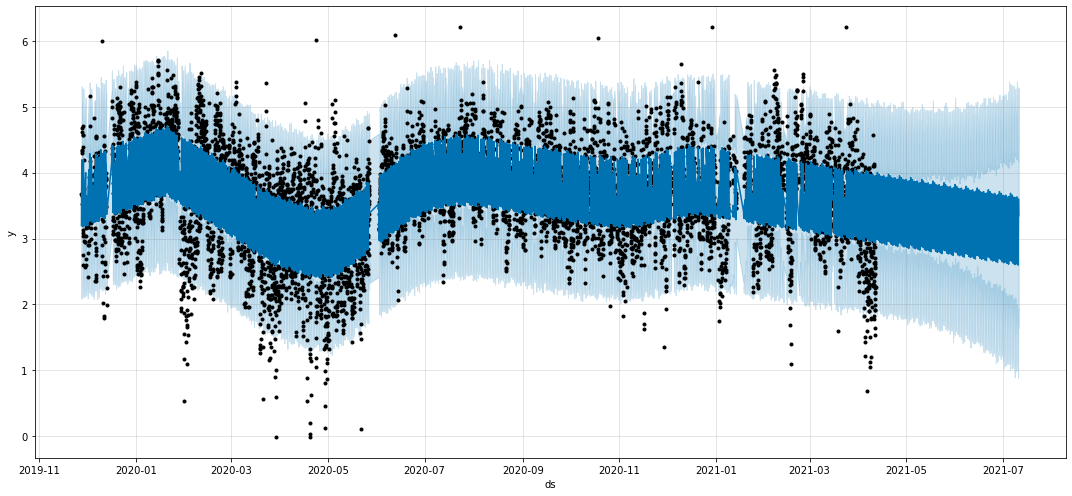

In [46]:
fig1 = model_default.plot(forecast, figsize=(15,7))


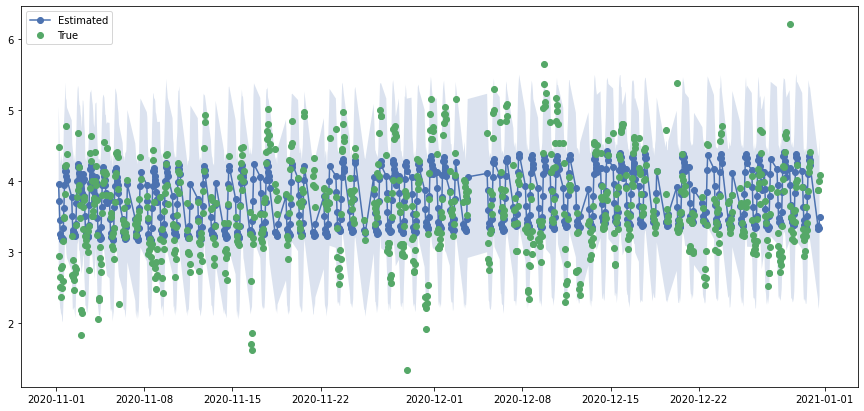

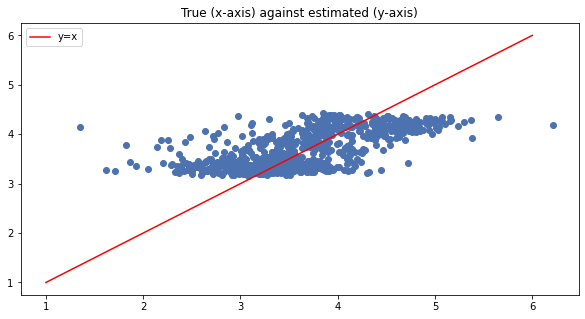

In [50]:
plot(forecast, train_df, '2020-11', '2020-12')

# autocorrelation 
plot of the residuals, i.e., true value minus predicted value.

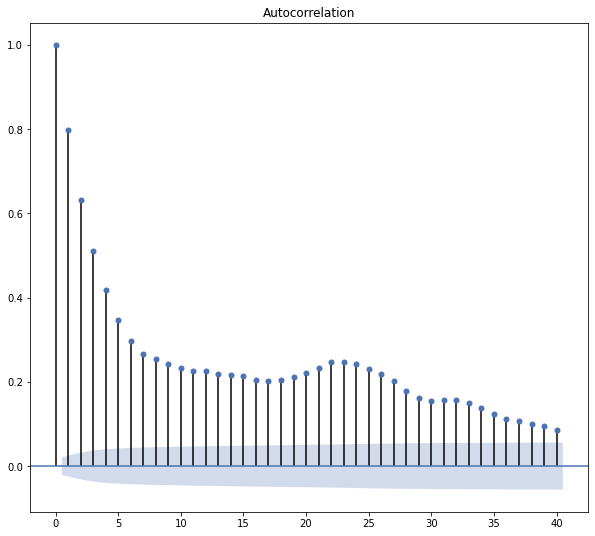

In [51]:
acf_res(forecast, train_df)

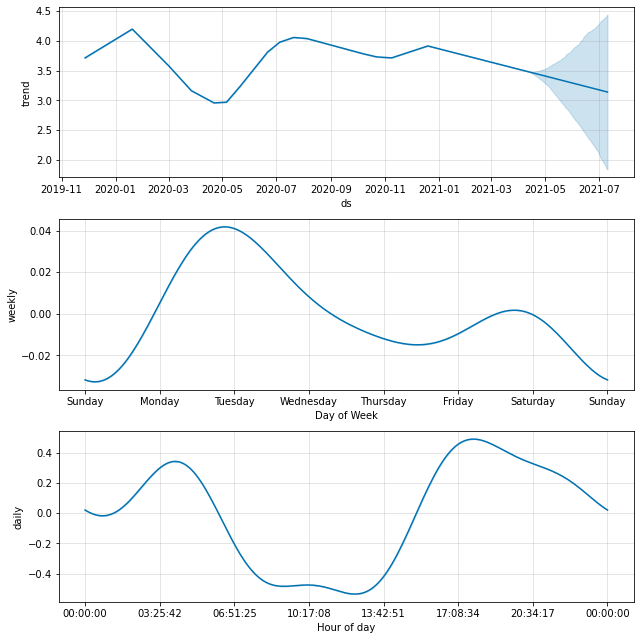

In [52]:
fig2 = model_default.plot_components(forecast)

the default model correctly identifies it

# Better Prophet model
# Fitting the model

In [53]:
train_df, val_df, test_df = train_val_test_split(to_log(df, ['y']))
train_df = add_custom_seasonality(train_df)
val_df = add_custom_seasonality(val_df)
test_df = add_custom_seasonality(test_df)
future = add_custom_seasonality(future)

In [54]:
a = pd.date_range(start='2019-11-01', end='2020-01-08', freq='1D').to_series()
b = pd.date_range(start='2020-03-20', end='2020-06-08', freq='1D').to_series()
c = pd.date_range(start='2020-07-20', end='2020-12-08', freq='1D').to_series()
d = pd.date_range(start='2021-10-20', end='2021-12-25', freq='1D').to_series()


christmas_newyear = pd.DataFrame({
    'holiday': 'christmas_newyear',
    'ds': pd.concat([a, b, c, d], axis=0).values
})

In [57]:
def better_prophet():
    model_improved = Prophet(
        changepoint_prior_scale=0.5,
        daily_seasonality=False,
        holidays = christmas_newyear,
        interval_width=0.95)

    # The higher the fourier_order, the more wiggly the seasonality component becomes
    model_improved.add_seasonality(name='spring_weekday', period=1, fourier_order=12, condition_name='spring_weekday')
    model_improved.add_seasonality(name='spring_weekend', period=1, fourier_order=12, condition_name='spring_weekend')
    model_improved.add_seasonality(name='summer_weekday', period=1, fourier_order=12, condition_name='summer_weekday')
    model_improved.add_seasonality(name='summer_weekend', period=1, fourier_order=12, condition_name='summer_weekend')
    model_improved.add_seasonality(name='autumn_weekday', period=1, fourier_order=12, condition_name='autumn_weekday')
    model_improved.add_seasonality(name='autumn_weekend', period=1, fourier_order=12, condition_name='autumn_weekend')
    model_improved.add_seasonality(name='winter_weekday', period=1, fourier_order=12, condition_name='winter_weekday')
    model_improved.add_seasonality(name='winter_weekend', period=1, fourier_order=12, condition_name='winter_weekend')
    model_improved.add_country_holidays(country_name='USA')
    return model_improved

In [58]:
model_improved = better_prophet()
model_improved.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


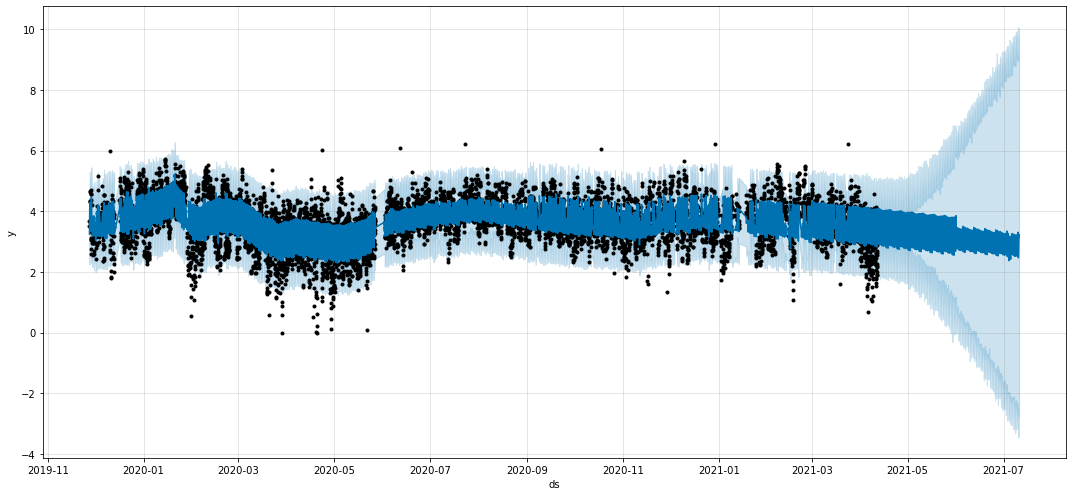

In [59]:
forecast_improved = model_improved.predict(future)

fig1 = model_improved.plot(forecast_improved, figsize=(15,7))

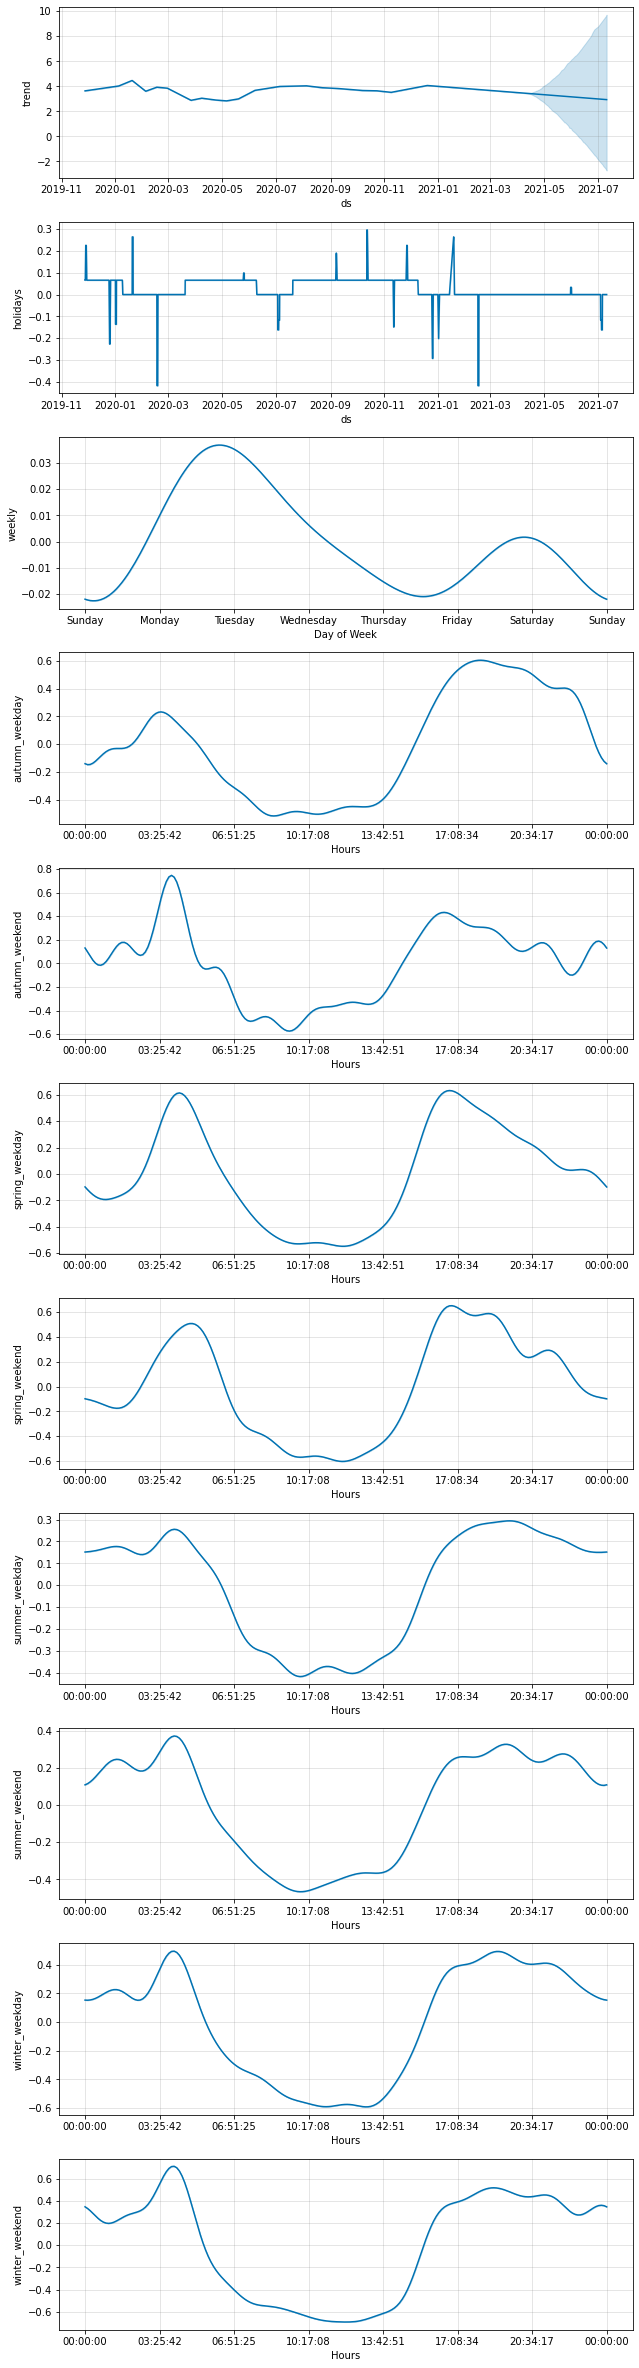

In [60]:
fig2 = model_improved.plot_components(forecast_improved)

# Cross-validation

In [62]:
df_cv = cross_validation(model_improved, initial='8766 hours', period='1440 hours', horizon='720 hours', parallel="processes")

INFO:prophet:Making 2 forecasts with cutoffs between 2021-01-11 23:00:00 and 2021-03-12 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021840BCBCD0>


In [63]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days 07:00:00,0.154780,0.393420,0.313658,0.081258,0.068739,0.082002,1.000000
1,4 days 08:00:00,0.150512,0.387959,0.307209,0.079785,0.066774,0.080405,1.000000
2,4 days 09:00:00,0.147275,0.383764,0.303205,0.079022,0.065940,0.079511,1.000000
3,4 days 10:00:00,0.140068,0.374257,0.295526,0.077430,0.064802,0.077716,1.000000
4,4 days 11:00:00,0.137070,0.370230,0.292380,0.076962,0.064802,0.077191,1.000000
...,...,...,...,...,...,...,...,...
521,29 days 20:00:00,1.120607,1.058587,0.914678,0.330847,0.223892,0.269732,0.924731
522,29 days 21:00:00,1.123201,1.059812,0.918098,0.332651,0.223892,0.270708,0.930108
523,29 days 22:00:00,1.118783,1.057725,0.917767,0.333038,0.223892,0.270595,0.935484
524,29 days 23:00:00,1.116474,1.056633,0.916712,0.332840,0.223451,0.270143,0.935484


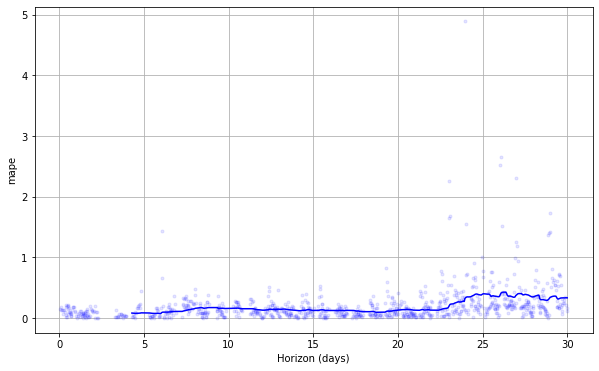

In [64]:
fig_cv = plot_cross_validation_metric(df_cv, metric='mape')

# Model selection

In [66]:
train, test = train_val_test_split(to_log(add_custom_seasonality(df.reset_index()), ['y']).set_index('ds'), validation=False)
model_final = better_prophet()
model_final.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [67]:
future = model_final.make_future_dataframe(periods=len(test), freq='H')
future = add_custom_seasonality(future)
forecast = model_final.predict(future)

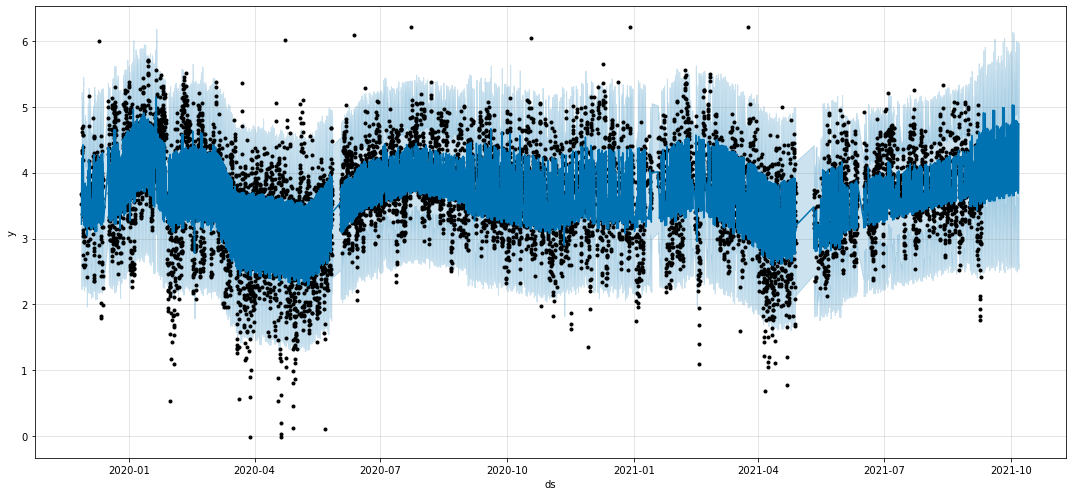

In [68]:
fig1 = model_final.plot(forecast, figsize=(15,7))